In [1]:
import pandas as pd, numpy as np, sys, scipy.stats as ss

sys.path.insert(0, '/home/croth/QTL-functions/SCRIPTS/')
import qtlfunctions as qtlfun

from sklearn import feature_selection as fs
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline

from PIL import Image

In [2]:
## Set relative regions of MAT locus
MAT = np.array([1529240,1661861])

## Set QTL ylabel
myylabel = 'I ( G$_n$ ; $S$ )'

## Set MAT lables
## For MATalpha
matal = '$MAT\mathrm{\u03B1}$'

## MATa
mata =  r'$MAT\bf{a}$'

## Set paths
## Phenotype path
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype.csv'

## Centromere path
centpaths = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'

## GFF path
gffpath = '/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz'

## SNPs 
snppath = '../GENOTYPE/FILTERED/B3502_F1_variants.csv.gz'

## chromosome map
chrommappath = '../GENOTYPE/Chromosomemap.csv'

In [3]:
## Load in chromosome map
chrommap = pd.read_csv(chrommappath)

In [4]:
## Bring in genotype dataframe
geno = pd.read_csv(snppath, index_col=0)

## Add chromosomes
geno['Chrom'] = geno.Chromosome 

## View head
geno.head()

,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,MAF,...,A33,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right,Chrom
index,,,,,,,,,,,,,,,,,,,,,
14046,AE017341.1,474535,7741.50,1,G.C,1,1,SNP,1.0,0.967391,...,0.0,0.0,0.0,2300501,0,1150250.5,1,942544,993056,1
15314,AE017341.1,530127,124679.00,1,C.G,1,1,SNP,1.0,0.597826,...,0.0,0.0,0.0,2300501,0,1150250.5,1,942544,993056,1
24655,AE017341.1,835830,2229.39,1,C.A,1,1,SNP,1.0,0.989130,...,0.0,0.0,0.0,2300501,0,1150250.5,1,942544,993056,1
26178,AE017341.1,884617,106015.00,1,AGG.AGA,3,3,MNP,1.0,0.445652,...,0.0,1.0,0.0,2300501,0,1150250.5,1,942544,993056,1
31377,AE017341.1,1032506,140296.00,1,T.C,1,1,SNP,1.0,0.456522,...,0.0,1.0,0.0,2300501,0,1150250.5,1,942544,993056,1


In [5]:
geno.shape

(1814, 109)

In [6]:
## Bring in centromeres datarame
centlocs = pd.read_csv(centpaths,index_col=0)
centlocs.head()

,Chromosome,Left,Right
0,1,942544,993056
1,2,860449,900038
2,3,806551,906800
3,4,222000,273992
4,5,784047,849321


In [7]:
## Bring in phenotype data from Dr. Sheng Sun
pheno = pd.read_csv(phenopath)
pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary
0,A_01,1.0,N,0.0,Yeast,0.0,0.0,0.0
1,A_02,1.0,Y,0.0,Selfing,1.0,2.0,2.0
2,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0
3,A_04,1.0,L,0.0,Large Cell,1.0,1.0,1.0
4,A_06,2.0,L,0.0,Large Cell,1.0,1.0,1.0


In [8]:
## Correct strain names between phenotype and genotype
## Intilize lists
corrected = []
missing_geno = []

## Iterate thru strains
for s in pheno.Strain.unique():
    
    ## Correct strain name
    if s in geno.columns:
        corrected.append(s)
    elif s[0]+'_'+s[1:] in geno.columns:
        corrected.append(s[0]+'_'+s[1:])
    elif ''.join(s.split('_')) in geno.columns:
        corrected.append(''.join(s.split('_')))
    
    ## Append missing
    else:
        missing_geno.append(s)
        corrected.append(np.nan)

## Add corrected name column        
pheno['Genotyped'] = corrected

## Set index
pheno.index = pheno.Genotyped

## Print missing
missing_geno

[]

In [9]:
clones = pd.read_csv('../GENOTYPE/Clones.csv')
clones.head()

,S1,S2
0,A24,A27
1,A43,A44
2,B_14,I641
3,B_14,I643
4,B_14,I645


In [10]:
clone_group = clones.iloc[1].values
clone_group = np.unique(np.concatenate(clones.iloc[4:7].values))
pheno[(pheno.Genotyped.isin(clone_group))]

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary,Genotyped
Genotyped,,,,,,,,,
I645,I645,NaN,N,1.0,Yeast,0.0,0.0,0.0,I645
B_14,B_14,NaN,N,1.0,Yeast,0.0,0.0,0.0,B_14
B_22,B_22,NaN,L,1.0,Large Cell,1.0,1.0,1.0,B_22
B_23,B_23,NaN,L,1.0,Large Cell,1.0,1.0,1.0,B_23
B_30,B_30,NaN,N,1.0,Yeast,0.0,0.0,0.0,B_30


In [11]:
clones_kept = ['A27','A43','B_14','B_22','B_30']
clones_dropped = [s for s in np.unique(np.concatenate(clones.values)) if s not in clones_kept]
len(clones_dropped)

7

In [12]:
## Add a clone code column
## tells us if a sample is a clone or not
pheno['Clone'] = 0

## gather index of lcones
clones_todrop = pheno[(pheno.Genotyped.isin(clones_dropped)) | 
                  (pheno.Strain.isin(clones_dropped))].index

## Set clones column for these to one
pheno.loc[clones_todrop,'Clone'] = 1

In [13]:
## Gather unique haplotypes for testing
samples = pheno[(pheno.Clone==0)].Genotyped.values
len(samples)

73

In [14]:
MATcum = MAT+chrommap[(chrommap.Chromosome==4)].Cumlen.min()

In [15]:
chrommap['Chrom'] = chrommap.Chromosome

In [16]:
## Bring in gridspec
import matplotlib.gridspec as gridspec

In [17]:
pheno_names = pheno.sort_values(['Quadrary']).Phenotype_Description.unique()

In [18]:
labels = [[pheno_names[0]]+['Non-yeast'], list(pheno_names[:3]), list(pheno_names)]
labels

[['Yeast', 'Non-yeast'],
 ['Yeast', 'Large Cell', 'Selfing'],
 ['Yeast', 'Large Cell', 'Selfing', 'Transgressive Selfing']]

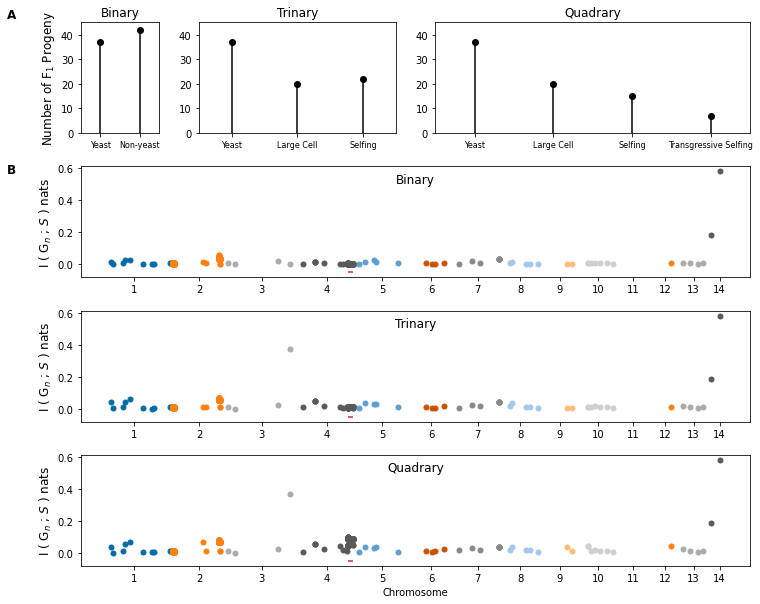

In [19]:
fig = plt.figure(figsize=(12,10))
fig.set_facecolor('w')

gs = fig.add_gridspec(4, 6)

f_ax1 = fig.add_subplot(gs[0,0])
f_ax2 = fig.add_subplot(gs[0,1:3])
f_ax3 = fig.add_subplot(gs[0,3:])

axes = [f_ax1,f_ax2,f_ax3]

    ## Iterate thur phenotypes
for i,pheno_label in enumerate(pheno.columns[5:-2]):
    
    plt.sca(axes[i])
    
    phc = pheno.groupby([pheno_label]).count()['Strain'].values

    plt.vlines(np.arange(len(phc)),np.zeros(len(phc)),phc,color='k')
    plt.plot(np.arange(len(phc)),phc,'o',color='k');
    
    plt.xlim(-0.5,len(phc)-0.5)
    plt.ylim(0,45)
    plt.xticks(np.arange(len(phc)),labels[i],fontsize=8)
    plt.ylabel('Number of F$_1$ Progeny' if i == 0 else None,fontsize=12)
    plt.title(pheno_label,fontsize=12)

    
    qtl_ax = fig.add_subplot(gs[i+1,:])
    
    ## Copy loci df and append phenotype set above
    loci = geno[samples].drop_duplicates().copy()
    usnps = geno[samples].drop_duplicates().copy().T
   
    ## Gather phenotype
    usnps['Y'] = pheno.loc[samples,pheno_label]
    
    ## Cunduct QTL mapping
    miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,discrete_features=True)
    loci['MIobs'] = miobs[:-1]
    
    ## Merge with genotype dataframe
    res = geno.merge(loci)
    
    ## draw manhattan
    qtlfun.manhattan(res,pval='MIobs',ms=10,chrmap=chrommap,
                     xlabel='' if i <2 else 'Chromosome',
                     ylabel=None,ax=qtl_ax,fs=10);
    
    plt.hlines(-0.05,*MATcum,color='tab:red')
    plt.ylabel(myylabel+' nats',fontsize=12)
    plt.title(pheno_label,y=0.8,fontsize=12);

plt.subplots_adjust(hspace=0.3,wspace=0.5)

fig.text(0.04,0.886,'A',fontsize=12,fontweight='bold')
fig.text(0.04,0.67,'B',fontsize=12,fontweight='bold')
plt.savefig('../FIGURES/Supplementary_Figure_S4.png',dpi=300,bbox_inches='tight');

In [21]:
## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()

## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Binary'
#pheno_label = 'Trinary'
pheno_label = 'Quadrary'

## Copy loci df and append phenotype set above
usnps = loci.copy().T
Y = pheno.loc[samples,pheno_label]
usnps['Y'] = Y
usnps.shape

(73, 72)

In [22]:
## QTL MAPPING!!!
## Single locus effect
miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,discrete_features=True)
## append as column to snp dataframe
#res = usnps.T
loci['MIobs'] = miobs[:-1]

## Merge with genotype dataframe
res = geno.merge(loci)

## Print max
res.MIobs.max()

0.5813304245633744

In [23]:
## Conduct permutations to
## establish genome-wide signfiance
## Set thres to None to run this code
thres = 0.12

## Initialise permutatons setting to 10k
perms = []
nperm = 10000

## Conduct permutations if previous threhold is None
if thres is None:
    while len(perms) < nperm:
        
        ## permute phenotypes
        permy = np.random.permutation(Y)
        
        ## add to dataframe
        usnps['Y'] = permy
        
        ## Calcualte mutual information with discrete features
        MIobsp = fs.mutual_info_classif(usnps.values,permy,discrete_features=True)
        
        ## append results
        perms.append(np.max(MIobsp[:-1]))
    
    ## Set alpha and calculate permutations threshold
    alpha = 95 if nperm  == 1000 else 99
    thres = np.percentile(perms,alpha)
        
## print threshold
thres

0.12

In [24]:
## Plot null distribution of association
if (thres is not None) and (len(perms)==nperm):

    plt.hist(perms,alpha=0.5,color='grey');
    plt.xlabel('$I$ ( G$_n$ ; S ) nats',fontsize=12);
    plt.ylabel('Number of Permutations',fontsize=12);
    plt.title('Null Distribution of Association',fontsize=12);
    plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
    plt.text(thres,nperm/6,'\u03B1 = %s'%(0.05 if alpha == 95 else 0.01),fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
    plt.savefig('../FIGURES/MI_null_dist_%s.png'%nperm,
            dpi=100,bbox_inches='tight');

In [25]:
## Make chromsome plotting map
idxmap = list(np.arange(0,14,2)) + list(np.arange(0,14,2)+1)

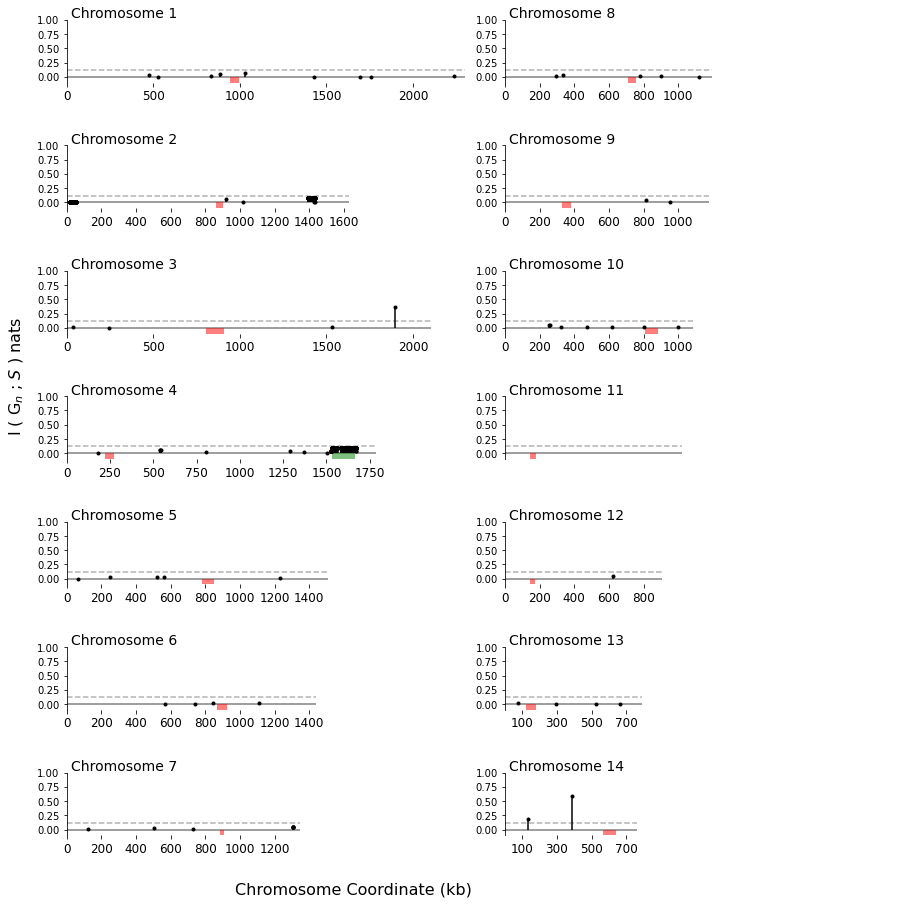

In [26]:
## Plot a Manhattan plot
fig,ax = plt.subplots(7,2,figsize=(15,15),sharex=False,sharey=False)
fig.set_facecolor('w')

## Set varialbles
centy = - 0.09
centw = 10
conversion = 1#np.log(2)

## Iterate over chromooems
for i,cm in chrommap.iterrows():
        
    ## Set iterater and axis
    thisax = ax.ravel()[idxmap[i]]
    plt.sca(thisax)
    
    ## Plot chromosome body and y-threshold of significance
    plt.hlines(0,0,cm.Length,color='k',linestyle='-',alpha=0.5)
    plt.hlines(thres/conversion,0,cm.Length,color='k',linestyle='--',alpha=0.3)
    
    ## Plot centromere
    plt.hlines(centy,cm.Left,cm.Right,color='r',linewidth=centw,alpha=0.5)
    
    ## Plot MAT
    if (cm.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',linewidth=centw,alpha=0.5)
    
    c = res[(res.Chromosome==cm.Chromosome)]
    ## Plot mutual info
    plt.vlines(c.Pos,0,c.MIobs/conversion,color='k')
    plt.plot(c.Pos,c.MIobs/conversion,'k.')
    
    ## Annotate chromosome
    plt.text(x=0.01,y=1.1,va='center',ha='left',s='Chromosome %s'%(cm.Chromosome),fontsize=14,transform=thisax.transAxes)
    
    ## Adjust xticks
    xp,xl = plt.xticks()
    xpz = xp[1:-1] if i < 12 else xp[1:-1][1::2]
    xpz = xpz[(xpz<c.Length.max())]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    ## Set x and y limis
    plt.xlim(0,geno.Length.max())
    plt.ylim(centy-0.01,1)
    
    ## Adjust yticks
    plt.yticks(np.arange(0,1.25,.25))
    
    ## Remove spines
    [thisax.spines[t].set_visible(False) for t in ['top','right','bottom']]

    
## Adjust plot
plt.subplots_adjust(wspace=0.1,hspace=1);

## Annotatle axis
fig.text(0.5,0.075,'Chromosome Coordinate (kb)',fontsize=16,va='center',ha='right');
fig.text(0.07,0.5,myylabel+(' bits' if conversion != 1 else ' nats'),rotation=90,fontsize=16);

## Set save path, save, and close
savepath = '../FIGURES/QTL_IG_B3502_%s_filamentous_growth.png'%pheno_label
plt.savefig(savepath,dpi=200,bbox_inches='tight');

## Load in image, crop, and save
im = Image.open(savepath)
im_crop = im.crop((0, 0, 2025, 2520))
im_crop.save(savepath)

In [27]:
chromcolors = qtlfun.qtlcolormap

In [28]:
import matplotlib.image as mpimg

In [29]:
MATcum = MAT+chrommap[(chrommap.Chromosome==4)].Cumlen.min()

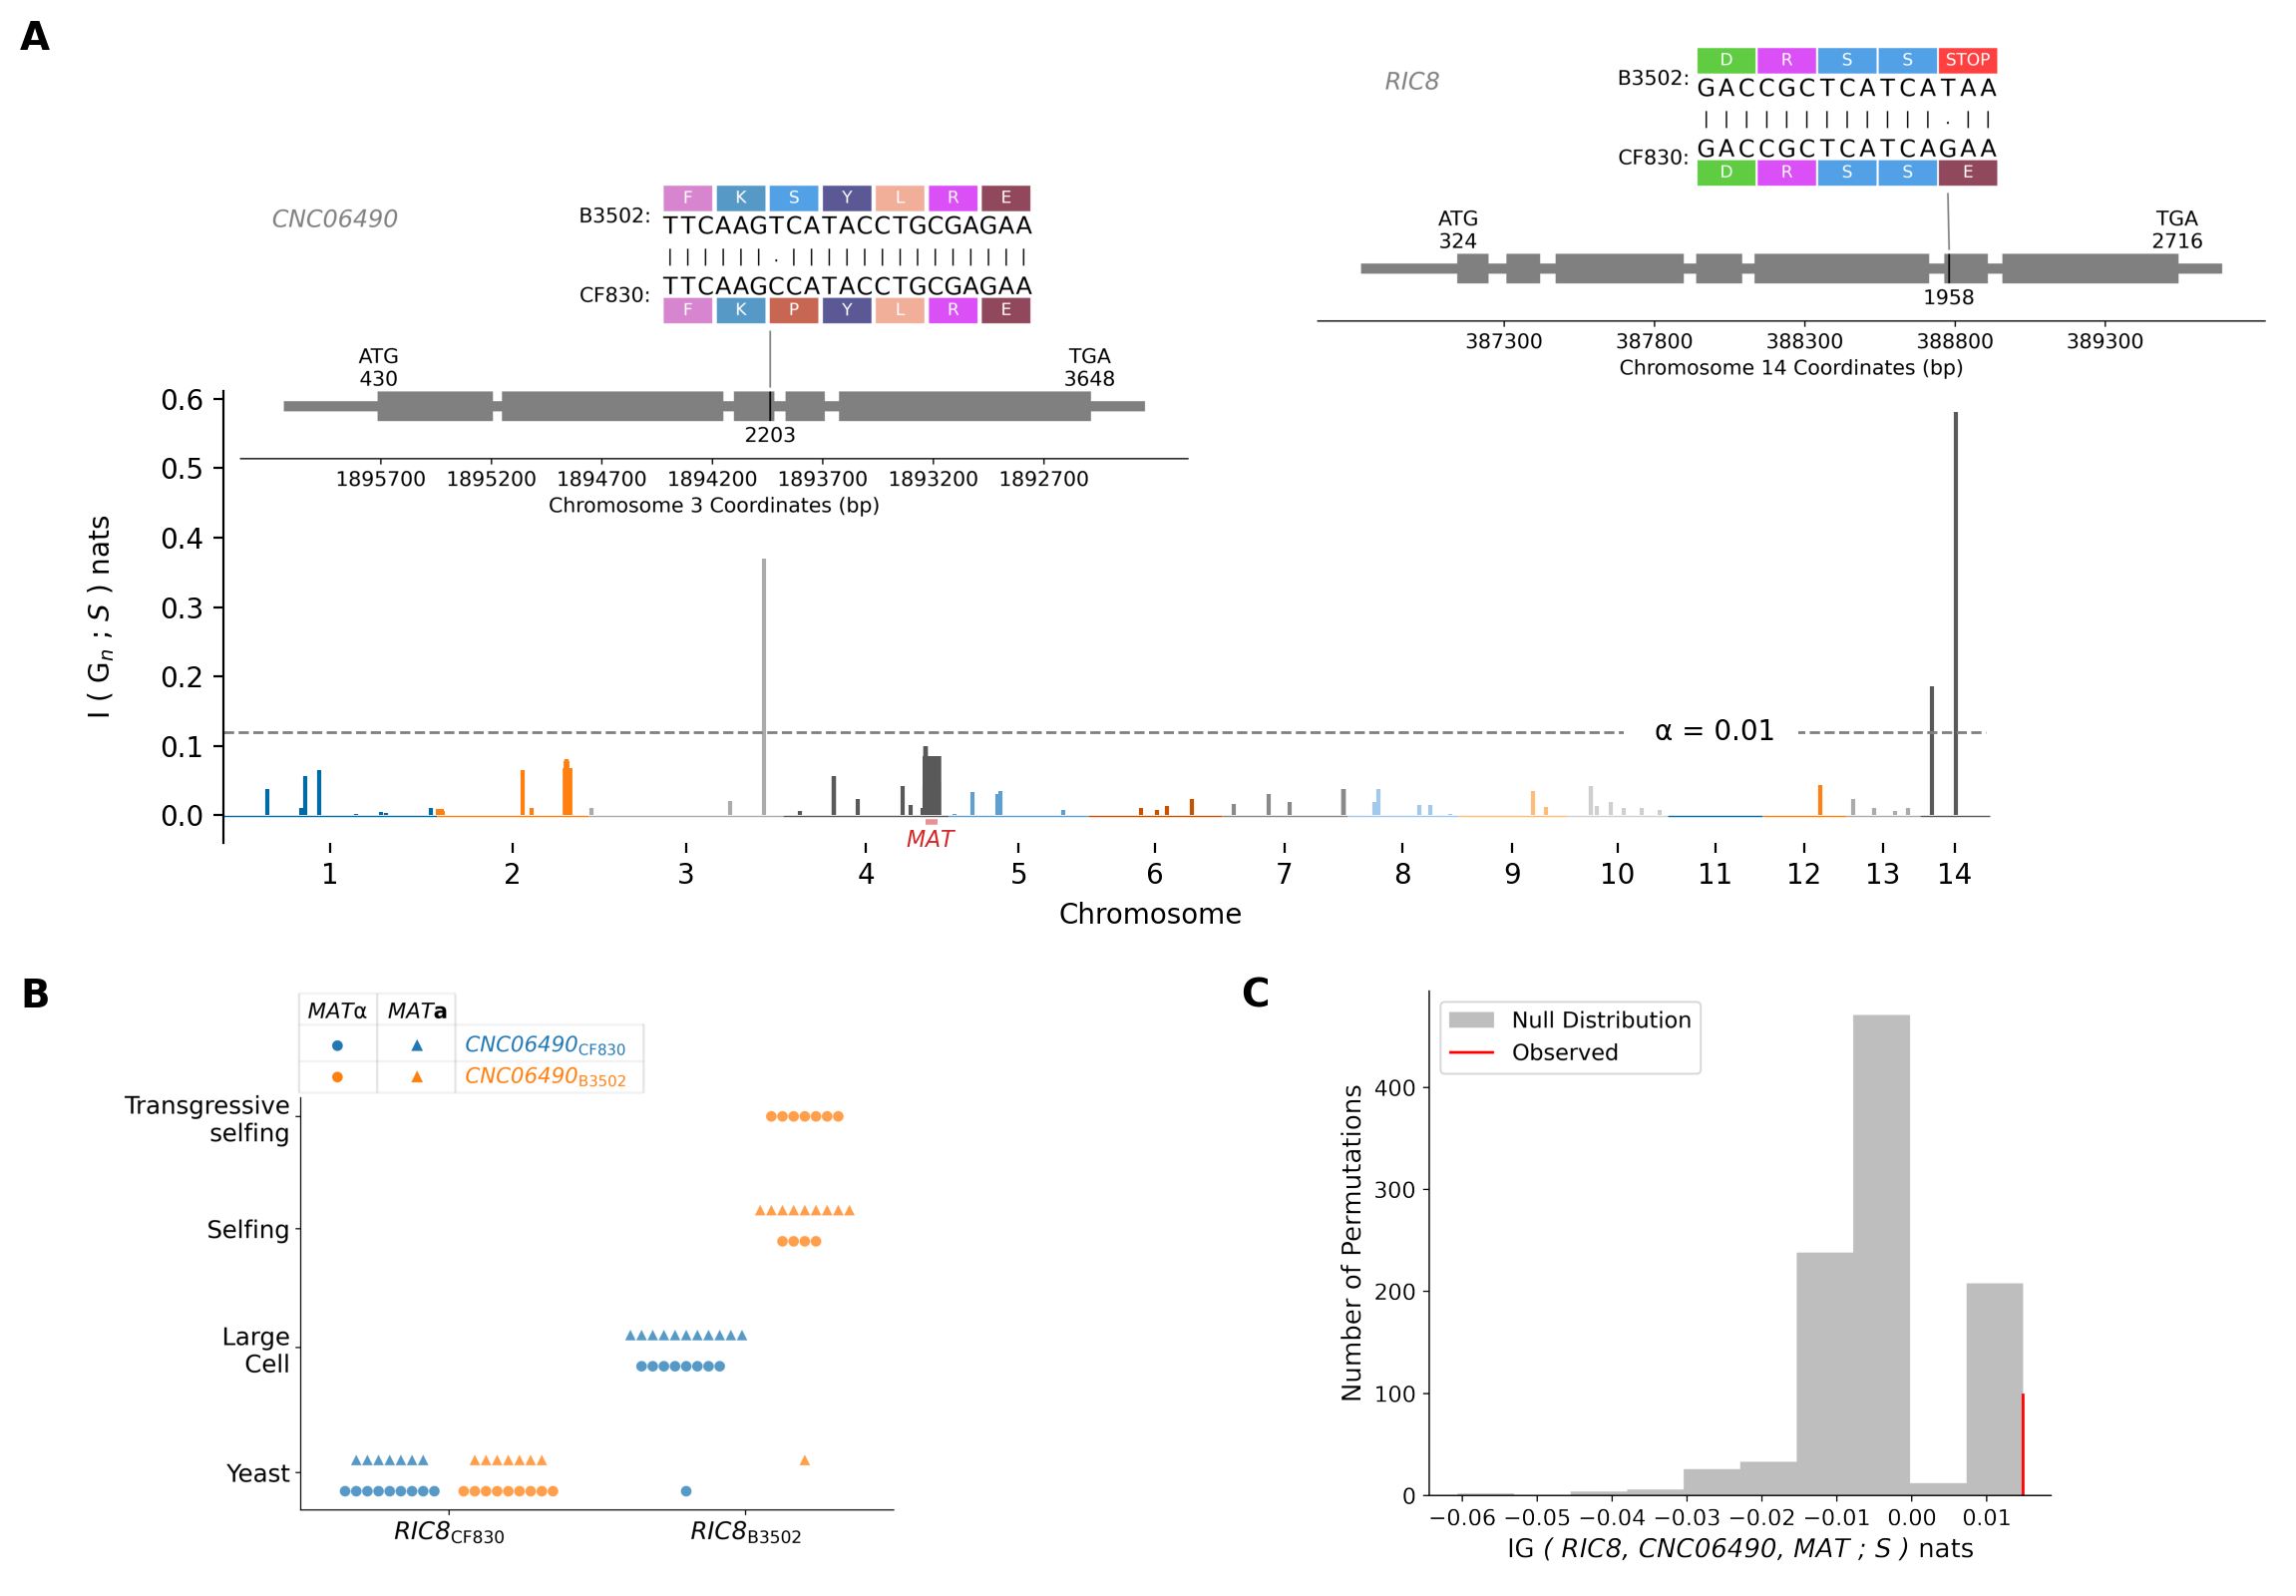

In [30]:
fig,ax = plt.subplots(1,1,figsize=(12,3),dpi=200)

for i, cr in chrommap.iterrows():
    
    chromcolor = chromcolors[i%len(chromcolors)]
    chrom = cr.Chromosome
    temp = res[(res.Chromosome==chrom)]
    plt.vlines(temp.Pos+temp.Cumlen,0,temp.MIobs,
               color=chromcolor,rasterized=True)
    plt.hlines(-0.001,cr.Cumlen,cr.Cumlen+cr.Length,
               linewidth=0.5,color=chromcolor,rasterized=True)
    
plt.hlines(thres,0,19*10**6,linewidth=1,linestyle='--',color='grey')
plt.xticks(chrommap.Midpts,chrommap.Chromosome,fontsize=10);
plt.xlim(0)
plt.xlabel('Chromosome',fontsize=10)
plt.ylabel(myylabel + ' nats\n',fontsize=10)

## Plot 
plt.hlines(-0.01,*MATcum,color='tab:red',linewidth=2,alpha=0.5)
plt.text(np.mean(MATcum),-0.02, s='$MAT$', ha='center',va='top',
         color='tab:red',transform=ax.transData,fontsize=8)

plt.hlines(thres,chrommap.Midpts[9]+70000,chrommap.Midpts[11]-70000,color='w')
plt.text(chrommap.Midpts[10],thres,'\u03B1 = %s'%0.01,
         fontsize=10,va='center',ha='center')

## Remove spines
[ax.spines[t].set_visible(False) for t in ['top','right','bottom']]

## Add axis for rho
rhobox = [-0.02,0.65,0.7,0.6]
rhoax = fig.add_axes(rhobox)
img = mpimg.imread('../FIGURES/CNC06490_RHO_B3502.png')
plt.sca(rhoax)
imgplot = plt.imshow(img)
plt.axis('off')

## Add axis for ric8
ricbox = [0.43,0.88,0.7,0.6]
ricax = fig.add_axes(ricbox)
img = mpimg.imread('../FIGURES/CNN01270_RIC8_B3502.png')
plt.sca(ricax)
imgplot = plt.imshow(img)
plt.axis('off');

## Add axis for phenotype by genotype plot
tilebox = [-0.26,-1.1,1,1]
tileax = fig.add_axes(tilebox)
img = mpimg.imread('../FIGURES/Selfing_phenotype_by_QTL.png')
plt.sca(tileax)
imagplot = plt.imshow(img)
plt.axis('off')

## Add axis for null dist of three-way IG
distbox = [0.24,-1.1,1,1]
distax = fig.add_axes(distbox)
img = mpimg.imread('../FIGURES/Three-way_IG_nulldist.png')
plt.sca(distax)
imagplot = plt.imshow(img)
plt.axis('off')

## SEction Lables
fig.text(0.04,1.45,'A',fontsize=14,fontweight='bold')
fig.text(0.04,-0.15,'B',fontsize=14,fontweight='bold')
fig.text(0.55,-0.15,'C',fontsize=14,fontweight='bold')

## SAve fig
plt.savefig('../FIGURES/Figure_3.pdf',dpi=600,bbox_inches='tight')

In [31]:
## Gather ancestors
ancestors = sorted([s for s in samples if len(s)>4])
ancestors

['B3502_A1', 'B3502_B1', 'CF830']

In [32]:
mafix = geno.columns.tolist().index('MAF')
lenix = geno.columns.tolist().index('Length')

strains = geno.columns[mafix+1:lenix]

## Gather progeny
progeny = sorted([s for s in strains if len(s)<=4])

## Gather ancestors
ancestors = sorted([s for s in strains if len(s)>4])

## Check work
assert len(progeny) + len(ancestors) == len(strains)

## Gather B3502 stocks
b3502 = [s for s in ancestors if s.split("_")[0]=='B3502']

## parents and progenitor strains
progenitors = [s for s in ancestors if s not in b3502]

In [33]:
## Find loci above threshold
sigloci = res[(res.MIobs>=thres)]
sigloci

,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,MAF,...,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right,Chrom,MIobs
482,AE017343.1,1894056,156278.0,1,G.A,1,1,SNP,1.0,0.434783,...,0.0,1.0,2105736,3932493,4985361.0,3,806551,906800,3,0.370218
1812,AE017356.1,134798,156819.0,1,G.C,1,1,SNP,1.0,0.500000,...,1.0,1.0,762694,18288602,18669949.0,14,566417,639012,14,0.185381
1813,AE017356.1,388777,140930.0,1,TCAG.TCAT,4,4,MNP,1.0,0.467391,...,1.0,0.0,762694,18288602,18669949.0,14,566417,639012,14,0.581330


In [34]:
import matplotlib.gridspec as gridspec

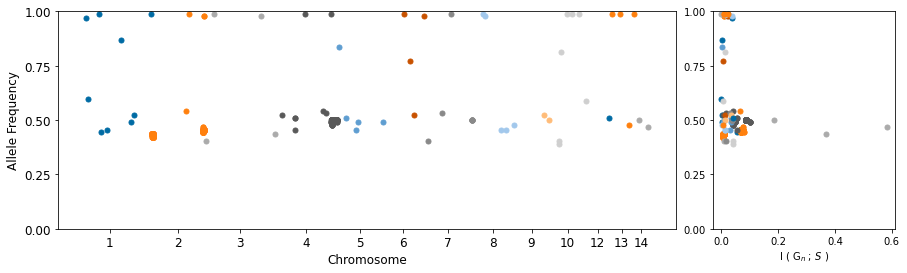

In [35]:
fig = plt.figure(figsize=(15,4))
fig.set_facecolor('w')
gs = fig.add_gridspec(1, 4)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax2 = fig.add_subplot(gs[0,-1])

qtlfun.manhattan(res,pval='MAF',ms=10,ylabel='Allele Frequency',ylims=(0,1),ax=f_ax1);
plt.yticks([0,0.25,0.5,0.75,1]);

plt.sca(f_ax2)

for i,(j,c) in enumerate(res.groupby('Chromosome')):
    plt.plot(c.MIobs,c.MAF,'.',
             color=qtlfun.qtlcolormap[i%len(qtlfun.qtlcolormap)],ms=10)
    
plt.ylim(0,1);plt.xlabel(myylabel)
plt.yticks([0,0.25,0.5,0.75,1]);
plt.savefig('../FIGURES/Allele_Frequency_and_Mutual_Information.png',dpi=200,bbox_inches='tight')

In [36]:
## drop clones
pheno.drop(pheno[(pheno.Clone==1)].index,axis=0,inplace=True)

In [37]:
## append Genotypes of QTL and MAT
pheno.loc[pheno.index,'IRK7'] = sigloci[(sigloci.Chrom==14) & (sigloci.Pos<200000)][pheno.index].values[0]
pheno.loc[pheno.index,'RIC8'] = sigloci[(sigloci.Chrom==14) & (sigloci.Pos>300000)][pheno.index].values[0]
pheno.loc[pheno.index,'RHO'] = sigloci[(sigloci.Chrom==3)][pheno.index].values[0]
pheno.loc[pheno.index,'MAT'] = np.round(geno[(geno.Chrom==4) & (geno.Pos>=np.min(MAT)) & (geno.Pos<=np.max(MAT))][pheno.index].mean(),1)

In [38]:
pheno.to_csv("../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype_QTL.csv",index=False)

In [39]:
geno[(geno.Chrom==4) & (geno.Pos>=np.min(MAT)) & (geno.Pos<=np.max(MAT))].shape

(1240, 109)

In [40]:
pheno.MAT.sum()

35.0

In [41]:
ss.pearsonr(pheno[pheno_label].values, pheno.RIC8.values)[0]**2

0.6265766454199743

In [42]:
ss.pearsonr(pheno[pheno_label].values,pheno.RHO.values)[0]**2

0.13533451438906652

In [43]:
# activate latex text rendering
#rc('text', usetex=True)

In [44]:
pheno_labels = pheno.sort_values('Quadrary').Phenotype_Description.unique()
pheno_labels = list(pheno_labels[:-1]) + ['\nS'.join(pheno_labels[-1].split(' s'))]

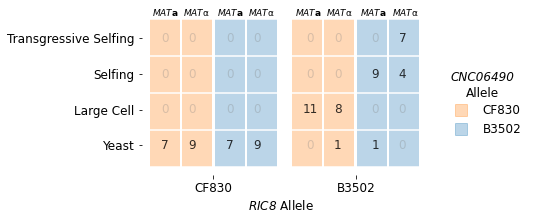

In [45]:
## Make a phenotype by genotype plot
## Call figure and set face color
fig,ax = plt.subplots(1,1,figsize=(5,3))
fig.set_facecolor('w')

## turn off spiones 
[ax.spines[t].set_visible(False) 
 for t in ['top','right','left','bottom']]

## Set ylabels
yphenos = ['Non-filamentous','Filamentous','Large Cells']
y = pheno.loc[samples,pheno_label].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']

## RHO allele
rho = pheno.loc[samples,'RHO']

## Make boxes
ws = 0.05
bs = 0.1
#box = [(0,0.5-ws),(0.5+ws,1),(1+bs,1.5+bs-ws),(1.5+bs+ws,2+bs)]
tc = ['tab:orange','tab:blue','tab:orange','tab:blue']

## Plot orange and blue rectangles
[plt.vlines(k+(ws if i>1 else 0),0,1,linewidth=62,alpha=.3,color=tc[i]) 
 for i,k in enumerate(np.arange(0,1,0.25))]

## plot vertical dashed white lines
[plt.vlines(k+(0.05 if i>1 else 0),0,1,linewidth=2,color='w') 
 for i,k in enumerate(np.arange(0,1.25,0.25))]

## Plot horizontal white lines over them
[plt.hlines(k,-0.25,1,color='w') for k in np.linspace(0,1,5)]

## Set yspacing
yspacing = np.linspace(0.15,0.87,4)

## Add yticks and ytick labels
plt.yticks(yspacing,labels=pheno_labels,rotation=0,fontsize=12)

## annotate xticks and xlabels
plt.xticks([0.125,.675],['B3502','CF830'][::-1],fontsize=12)
plt.xlabel(r'RIC8 $\rm{Allele}$',fontsize=12,fontstyle='italic');

## plot squres for making a custome legend
plt.plot(1.25,0.5,'s',color='tab:orange',alpha=0.3,label='CF830')
plt.plot(1.25,0.5,'s',color='tab:blue',alpha=0.3,label='B3502')

## call legend
plt.legend(bbox_to_anchor=(1.4,0.5),ncol=1,
           fontsize=12,markerscale=2,frameon=False)

## customize the title of legend with italic gene name
#plt.title('CNC06490\n',x=1.22,y=0.45,fontsize=14,fontstyle='italic');

plt.text(x=1.22,y=0.55,s='CNC06490\n',fontsize=12,
         fontstyle='italic',va='center',ha='center',
         transform=ax.transAxes)
plt.text(x=1.22,y=0.5,s='Allele',fontsize=12,
         va='center',ha='center',
         transform=ax.transAxes)

## Set phenotype label
newpheno_label = 'Quadrary'
for p,pt in enumerate(sorted(pheno[newpheno_label].unique())):
    for gt1 in [0,1]:
        for gt2 in [0,1]:
            for gt3 in [0,1]:
                
                gn = pheno[(pheno[newpheno_label]==pt) & 
                       (pheno.RIC8==gt1) & 
                       (pheno.RHO==gt2) & 
                       (pheno.MAT==gt3) &
                       (pheno.index.isin(samples))].shape[0]
                
                #if gn == 0:
                #    continue
            
                plt.text(np.arange(-0.02,1,0.25)[gt2+(2*gt1)] +(0.065 if gt3 == 0 else -0.04) + (ws + 0.01 if gt2+(2*gt1)>=2 else 0),
                     yspacing[p],gn,color = 'k' if gn > 0 else 'grey',
                     alpha = 0.8 if gn > 0 else 0.3,
                        va='center',ha='center',fontsize=12)

plt.xlim(-0.15,.925);

maty = 1.02

matax = [-0.11,0.14,0.44,0.69]
matalx = [0.01,0.26,0.56,0.815]

[plt.text(mx,maty,mata,fontsize=9) for mx in matax]
[plt.text(mx,maty,matal,fontsize=9) for mx in matalx];


plt.savefig('../FIGURES/Selfing_phenotype_by_QTL_tile.png',
            dpi=400,bbox_inches='tight')

In [46]:
pheno[(pheno.RIC8==1) & (pheno.RHO==1) & (pheno.MAT==1)]

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary,Genotyped,Clone,IRK7,RIC8,RHO,MAT
Genotyped,,,,,,,,,,,,,,
A07,A_07,2.0,Y,0.0,Selfing,1.0,2.0,2.0,A07,0,1.0,1.0,1.0,1.0
A12,A_12,3.0,Y,0.0,Selfing,1.0,2.0,2.0,A12,0,0.0,1.0,1.0,1.0
A13,A_13,4.0,Y,0.0,Selfing,1.0,2.0,2.0,A13,0,1.0,1.0,1.0,1.0
A15,A_15,1.0,Y,0.0,Selfing,1.0,2.0,2.0,A15,0,1.0,1.0,1.0,1.0
A20,A_20,2.0,Y,0.0,Selfing,1.0,2.0,2.0,A20,0,0.0,1.0,1.0,1.0
A29,A_29,1.0,Y,0.0,Selfing,1.0,2.0,2.0,A29,0,1.0,1.0,1.0,1.0
B01,B_01,NaN,Y,0.0,Selfing,1.0,2.0,2.0,B01,0,1.0,1.0,1.0,1.0
B_14,B_14,NaN,N,1.0,Yeast,0.0,0.0,0.0,B_14,0,0.0,1.0,1.0,1.0
B3502_A1,B3502_A1,NaN,Y,2.0,Selfing,1.0,2.0,2.0,B3502_A1,0,1.0,1.0,1.0,1.0


In [47]:
gene_changes = pd.read_csv('/home/croth/Downloads/B3502/DATA/gene_changes.csv.gz')

In [48]:
gene_changes.Strain.unique()

array(['B3502_A1_Stock1', 'B3502_A7_Stock2', 'B3502_B1_Stock3',
       'B3502_B7_Stock4', 'B3502_C1_Stock7', 'B3502_D1_Stock6', 'CF830',
       'JEC20', 'JEC21', 'B3502_C1_Stock5'], dtype=object)

In [49]:
gffpath = '/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz'
gff = qtlfun.loadgff(gffpath)
gff.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
0,AE017352.1,VEuPathDB,gene,713524,714773,.,-1,.,ID=CNL06190;description=aldo-keto reductase%2C...,CNL06190,CNL06190
1,AE017352.1,VEuPathDB,mRNA,713524,714773,.,-1,.,ID=CNL06190-t26_1;Parent=CNL06190;description=...,CNL06190,CNL06190
2,AE017352.1,VEuPathDB,exon,713524,713666,.,-1,.,ID=exon_CNL06190-E5;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
3,AE017352.1,VEuPathDB,exon,713720,713815,.,-1,.,ID=exon_CNL06190-E4;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
4,AE017352.1,VEuPathDB,exon,713866,714350,.,-1,.,ID=exon_CNL06190-E3;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190


In [50]:
gene_changes[(gene_changes.Gene=='CNC06490') & 
             (gene_changes.Strain.isin(
                 ['B3502_A1_Stock1',
                  'B3502_B1_Stock3',
                  'B3502_B7_Stock4',
                  'CF830']))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description
365,B3502_A1_Stock1,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
367,B3502_B1_Stock3,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
368,B3502_B7_Stock4,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
372,CF830,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator


In [51]:
temp = sigloci[(sigloci.Chromosome==14) & (sigloci.Pos<300000)]

In [52]:
temp

,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,MAF,...,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right,Chrom,MIobs
1812,AE017356.1,134798,156819.0,1,G.C,1,1,SNP,1.0,0.5,...,1.0,1.0,762694,18288602,18669949.0,14,566417,639012,14,0.185381


In [53]:
gff[(gff.Seqid==temp.Seqid.min()) & (gff.Type=='gene') & (gff.Start<=temp.Pos.min()) & (gff.End>=temp.Pos.min())]

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
9807,AE017356.1,VEuPathDB,gene,133059,139111,.,1,.,ID=CNN00400;description=conserved hypothetical...,CNN00400,CNN00400


In [54]:
gene_changes[(gene_changes.Gene=='CNN00400') & 
             (gene_changes.Strain.isin(
                 ['B3502_A1_Stock1',
                  'B3502_B1_Stock3',
                  'B3502_B7_Stock4',
                  'CF830']))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description
1284,B3502_A1_Stock1,CNN00400,CNN00400-t26_1,1379.0,1379,1379,1,1,1,1,0,0,1,0,14,AE017356.1,133059,139111,+,conserved hypothetical protein
1286,B3502_B1_Stock3,CNN00400,CNN00400-t26_1,1379.0,1379,1379,1,1,1,1,0,0,1,0,14,AE017356.1,133059,139111,+,conserved hypothetical protein
1287,B3502_B7_Stock4,CNN00400,CNN00400-t26_1,1379.0,1379,1379,1,1,1,1,0,0,1,0,14,AE017356.1,133059,139111,+,conserved hypothetical protein
1291,CF830,CNN00400,CNN00400-t26_1,1379.0,1379,1379,1,1,0,1,0,0,1,0,14,AE017356.1,133059,139111,+,conserved hypothetical protein


In [55]:
sigloci[['B3502_B1','CF830','Alleles']]

,B3502_B1,CF830,Alleles
482,1.0,0.0,G.A
1812,1.0,0.0,G.C
1813,1.0,0.0,TCAG.TCAT


In [56]:
sigloci[['JEC21','JEC20']]

,JEC21,JEC20
482,0.0,0.0
1812,0.0,0.0
1813,0.0,0.0


In [57]:
temp

,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,MAF,...,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right,Chrom,MIobs
1812,AE017356.1,134798,156819.0,1,G.C,1,1,SNP,1.0,0.5,...,1.0,1.0,762694,18288602,18669949.0,14,566417,639012,14,0.185381


In [58]:
gff[(gff.Gene=='CNC06490') & (gff.Type=='CDS')].shape

(5, 11)

In [59]:
from sklearn.metrics import mutual_info_score as mis

In [60]:
for i,gt1 in sigloci[samples].iterrows():
    for j,gt2 in sigloci[samples].iterrows():
        if i<j:
            print(mis(gt1,gt2))

0.00011375761064086332
7.324386374113478e-05
0.18105693716901544


In [61]:
sigloci[samples]

,A01,A02,A03,A04,A06,A07,A08,A09,A10,A11,...,B_25,B_27,B_28,B_29,B_30,B_31,B_33,B3502_A1,B3502_B1,CF830
482,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1812,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1813,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [62]:
irk7 = sigloci[samples].T[1812]

In [63]:
ss.spearmanr(ric8,irk7)

SpearmanrResult(correlation=0.5843492038624621, pvalue=5.713014256949314e-08)

In [64]:
## How corrilated are these loci
sigloci[samples].T.corr(method='spearman')

,482,1812,1813
482,1.000000,-0.015083,0.012103
1812,-0.015083,1.000000,0.584349
1813,0.012103,0.584349,1.000000
